# SETUP

The first part of the code sets up the pca_wavelet network, the training comes later. Most of this code comes from the original authors

In [35]:
import sys
sys.path.append('../segmentation_helper')

import tensorflow as tf
import keras
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import data_loader as dl
import model_broker as mb
import os

In [36]:
tf.keras.backend.set_floatx("float64")

In [37]:
dataset = "birds"
test_size=300
loader = dl.DataLoader(IMAGE_SIZE=128,dataset=dataset)
img_ds = loader.import_processed_img()
seg_ds = loader.import_processed_seg()
cardinality = int(img_ds.cardinality())

img_test = img_ds.take(test_size)
seg_test = seg_ds.take(test_size)
img_train = img_ds.skip(test_size)
seg_train = seg_ds.skip(test_size)    

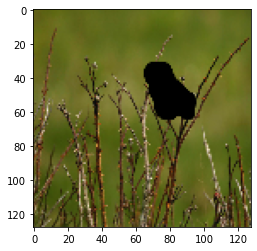

In [38]:
plt.imshow((next(iter(seg_train))[0]))

In [39]:
def scaledtanh(x): 
    return tf.math.tanh(x*0.5)

def scaledatanh(x):
    return tf.math.atanh(x)*2.0

keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 6 keep_max 12.0
keep_channels 6
ufilts.shape (1, 1, 1, 27, 6)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([54 54], shape=(2,), dtype=int32)
keep_channels 13 keep_max 96.0
keep_channels 13
ufilts.shape (1, 1, 1, 54, 13)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([117 117], shape=(2,), dtype=int32)
keep_channels 29 keep_max 832.0
keep_channels 29
ufilts.shape (1, 1, 1, 117, 29)
end loop 16.0
Starting level 3
Completing 8.0
pca shape tf.Tensor([261 261], shape=(2,), dtype=int32)
keep_channels 65 keep_max 7424.0
keep_channels 65
ufilts.shape (1, 1, 1, 261, 65)
end loop 8.0
saving to: models/birds_img
out.shape (1, 8, 8, 65)
keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype

array([[[0.52079797, 0.45246893, 0.41230088],
        [0.71232313, 0.69976091, 0.66403353],
        [0.90736037, 0.91544187, 0.92166245],
        ...,
        [0.18168995, 0.20543715, 0.21810925],
        [0.16443542, 0.13982055, 0.12645623],
        [0.18034118, 0.17032184, 0.15998416]],

       [[0.67877316, 0.61028385, 0.53427255],
        [0.50652909, 0.42743444, 0.34286895],
        [0.83030361, 0.79555327, 0.75942194],
        ...,
        [0.25622344, 0.23234528, 0.22786771],
        [0.16823491, 0.17215648, 0.17301673],
        [0.081014  , 0.08593056, 0.07670133]],

       [[0.43052813, 0.38509548, 0.29901052],
        [0.60668921, 0.53895384, 0.45235932],
        [0.33985046, 0.29223657, 0.25206995],
        ...,
        [0.13297862, 0.10362812, 0.10358552],
        [0.18177204, 0.20284232, 0.20243686],
        [0.31886992, 0.3091141 , 0.3142035 ]],

       ...,

       [[0.25755715, 0.23252863, 0.15411498],
        [0.6550262 , 0.55902052, 0.47827199],
        [0.71138561, 0

sample.shape (128, 128, 3)
pred.shape (1, 8, 8, 65)
recon.shape (128, 128, 3)


sample.dtype <dtype: 'float64'>
recon[0].dtype <dtype: 'float64'>
np.prod(sample.shape) 49152
psnr =  16.873729265241817
ncc =  [[1.         0.79628124]
 [0.79628124 1.        ]]
sample[30:34,30:34,0] tf.Tensor(
[[0.44510689 0.40919191 0.48315048 0.4695169 ]
 [0.4835794  0.57558572 0.41763294 0.27154878]
 [0.28440061 0.72505122 0.27976912 0.28914005]
 [0.38351956 0.66777921 0.38201952 0.43353918]], shape=(4, 4), dtype=float64)
recon[30:34,30:34,0] tf.Tensor(
[[0.5626859  0.46721488 0.5167125  0.53366692]
 [0.51508207 0.43219764 0.49668936 0.52967749]
 [0.5026074  0.48026246 0.47959036 0.47632016]
 [0.47984801 0.52948852 0.45982757 0.39443623]], shape=(4, 4), dtype=float64)


(16.873729265241817,
 array([[1.        , 0.79628124],
        [0.79628124, 1.        ]]))

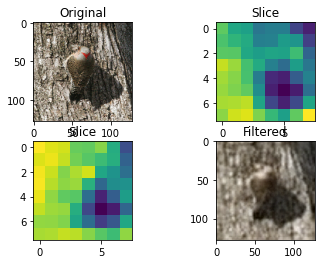

In [40]:
model_name = "img"
img_broker = mb.ModelBroker(trainset=img_train,
                            testset=img_test,
                            dirname=dataset+"_"+model_name,
                            keep_percent=0.1,
                            count=4,
                            sample_size=100,)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh)

imghead,imginvhead = img_broker.build_model()
imghead,imginvhead = img_broker.load_model()    
img_broker.check_build(imghead,imginvhead,img_test)

keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
self.mean.dtype <dtype: 'float64'>
Starting level 0
Completing 64.0
pca shape tf.Tensor([27 27], shape=(2,), dtype=int32)
keep_channels 6 keep_max 12.0
keep_channels 6
ufilts.shape (1, 1, 1, 27, 6)
end loop 64.0
Starting level 1
Completing 32.0
pca shape tf.Tensor([54 54], shape=(2,), dtype=int32)
keep_channels 13 keep_max 96.0
keep_channels 13
ufilts.shape (1, 1, 1, 54, 13)
end loop 32.0
Starting level 2
Completing 16.0
pca shape tf.Tensor([117 117], shape=(2,), dtype=int32)
keep_channels 29 keep_max 832.0
keep_channels 29
ufilts.shape (1, 1, 1, 117, 29)
end loop 16.0
Starting level 3
Completing 8.0
pca shape tf.Tensor([261 261], shape=(2,), dtype=int32)
keep_channels 65 keep_max 7424.0
keep_channels 65
ufilts.shape (1, 1, 1, 261, 65)
end loop 8.0
saving to: models/birds_seg
out.shape (1, 8, 8, 65)
keep_percent 0.24992947786237735
meanimg.dtype <dtype: 'float64'>
self.mean.dtype <dtype

array([[[0.29741284, 0.30055314, 0.13897227],
        [0.26915333, 0.28185245, 0.1051114 ],
        [0.27031252, 0.28986746, 0.13748468],
        ...,
        [0.06666667, 0.08235294, 0.03921569],
        [0.07310049, 0.08878677, 0.03921569],
        [0.07800413, 0.08584727, 0.03921569]],

       [[0.32166559, 0.32955968, 0.11755012],
        [0.28722379, 0.29623139, 0.09362698],
        [0.26362807, 0.27655149, 0.09469425],
        ...,
        [0.06639094, 0.08681066, 0.03921569],
        [0.07394278, 0.08962905, 0.03921569],
        [0.07293199, 0.08393076, 0.03921569]],

       [[0.31588542, 0.31766382, 0.07374675],
        [0.30694488, 0.30584073, 0.08228186],
        [0.25469565, 0.26642567, 0.05072093],
        ...,
        [0.0617075 , 0.08915848, 0.03921569],
        [0.07058273, 0.08626901, 0.03921569],
        [0.06840605, 0.08413828, 0.03921569]],

       ...,

       [[0.29586399, 0.24525817, 0.0980294 ],
        [0.30980945, 0.25490749, 0.10700181],
        [0.31265727, 0

sample.shape (128, 128, 3)
pred.shape (1, 8, 8, 65)
recon.shape (128, 128, 3)


sample.dtype <dtype: 'float64'>
recon[0].dtype <dtype: 'float64'>
np.prod(sample.shape) 49152
psnr =  28.040593177516946
ncc =  [[1.         0.95013875]
 [0.95013875 1.        ]]
sample[30:34,30:34,0] tf.Tensor(
[[0.18682599 0.17372856 0.16443518 0.13984351]
 [0.20392157 0.18554257 0.16291361 0.14260614]
 [0.20663297 0.17657951 0.16078432 0.14376031]
 [0.20223677 0.18902683 0.16494572 0.14509805]], shape=(4, 4), dtype=float64)
recon[30:34,30:34,0] tf.Tensor(
[[0.18838856 0.16426549 0.15877483 0.1418064 ]
 [0.18145157 0.16030514 0.15001174 0.13438182]
 [0.19081622 0.17597413 0.16694745 0.15884723]
 [0.18992652 0.18555943 0.1814544  0.15834208]], shape=(4, 4), dtype=float64)


(28.040593177516946,
 array([[1.        , 0.95013875],
        [0.95013875, 1.        ]]))

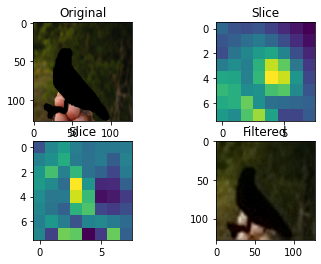

In [41]:
model_name = "seg"
seg_broker = mb.ModelBroker(trainset=seg_train,
                            testset=seg_test,
                            dirname=dataset+"_"+model_name,
                            keep_percent=0.1,
                            count=4,
                            sample_size=100)
                            #activity_regularizer = scaledtanh,
                            #inverse_activity_regularizer=scaledatanh)

seghead,seginvhead = seg_broker.build_model()
seghead,seginvhead = seg_broker.load_model()    
seg_broker.check_build(seghead,seginvhead,seg_test)

# Training

This is the loop used to find the variables to find A and b in y=Ax+b

In [ ]:
imgflat = np.prod(imghead(next(iter(img_train))[0]).shape)
segflat = np.prod(seghead(next(iter(seg_train))[0]).shape)
end_shape = next(iter(seg_train))[0].shape
n = 0.0

xxt = np.zeros([imgflat])
yxt = np.zeros([segflat])
x = np.zeros([imgflat])
y = np.zeros([segflat]) 

bar = tqdm.notebook.tqdm(total = int(img_train.cardinality()))

for item in iter(zip(img_train,seg_train)):

    bar.update(1)

    image = item[0][0]
    segmentation = item[1][0]

    imgdecom = imghead(image)
    segdecom = seghead(segmentation)

    mat = tf.reshape(imgdecom,[-1])
    segmat = tf.reshape(segdecom,[-1])

    cov = tf.matmul([mat],[mat],transpose_a=True)
    xxt += cov
    segcov = tf.matmul([mat],[segmat],transpose_a=True)
    yxt += segcov
    x+=mat
    y+=segmat
    n += 1

  0%|          | 0/5733 [00:00<?, ?it/s]

## Calculating A and B

This section uses the values found in the training loop to calculate values for A and B

In [ ]:
xxt = xxt - tf.matmul([x],[x],transpose_a=True)/n
yxt = yxt - tf.matmul([x],[y],transpose_a=True)/n

In [ ]:
inverse_xxt = tf.linalg.pinv(xxt)

In [ ]:
A = tf.linalg.matmul(inverse_xxt,yxt)

In [ ]:
b = (y - tf.linalg.matvec(A,x,transpose_a=True))/n

In [ ]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = tf.reshape(y_true,-1)
    y_pred_f =tf.reshape(y_pred,-1)
    intersection = tf.reduce_sum(y_true_f * y_pred_f,0)

    return float((2. * intersection+smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth))

In [ ]:
def iou_coef(y_true, y_pred,smooth=1):
  intersection = tf.reduce_sum(y_true * y_pred, 0)
  union = tf.reduce_sum(y_true,0)+tf.reduce_sum(y_pred,0)-intersection
  iou = tf.reduce_mean((intersection+1) / (union+1), 0)
  return float(iou)

In [ ]:
import random
threshold_intensity = 0.1
reconstruct = seghead(next(iter(seg_train))[0]).shape
skip = random.randint(0,300)
image,seg_base = next(iter(zip(img_train.skip(skip),seg_train.skip(skip))))
imgdecom = imghead(image[0])
imgdecom = tf.reshape(imgdecom,(1,-1))
segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
seg = seginvhead(tf.reshape(segdecom,(reconstruct)))

y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
y_pred = tf.cast(tf.reduce_min(seg[0],2)<=threshold_intensity,tf.float64)
plt.subplot(2,1,1)
plt.imshow(np.hstack([image[0],seg_base[0],seg[0]]))
plt.subplot(2,1,2)
plt.imshow(np.hstack([y_true,y_pred]))
print(dice_coef(y_true,y_pred))

In [ ]:

for split in ["train","test"]:
    if split == "train":
        img_ds, seg_ds = (img_train,seg_train)
    else:
        img_ds, seg_ds = (img_test,seg_test)
    n = int(seg_ds.cardinality())
    dice_coeff_vals = []
    for image,seg_base in iter(zip(img_ds, seg_ds)):
        imgdecom = imghead(image[0])
        imgdecom = tf.reshape(imgdecom,(1,-1))
        segdecom = tf.linalg.matvec(A,imgdecom,transpose_a=True)+b
        seg = seginvhead(tf.reshape(segdecom,(reconstruct)))
        y_true = tf.cast(tf.reduce_min(seg_base[0],2)==0,tf.float64)
        y_pred = tf.cast(tf.reduce_min(seg[0],2)<=threshold_intensity,tf.float64)
        dice_coeff_vals.append(dice_coef(y_true,y_pred))
    dice_coeff_mean = sum(dice_coeff_vals)/n
    dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5
    np.save(f"PCWN_CONV_{dataset}_{split}",dice_coeff_vals)